<a href="https://colab.research.google.com/github/kiamaikocoders/virtual-machine-pricing/blob/main/VM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The main goal of this project is to analyze and visualize Google Cloud Platform (GCP) Virtual Machine (VM) pricing data to understand cost-effectiveness and regional pricing differences.

Here's a breakdown of the key objectives:

1. **Data Loading and Preprocessing:** The project starts by importing necessary libraries and loading VM pricing data from a CSV file. The initial data is cleaned and prepared for analysis, including handling missing values and extracting discount percentages and region names from the bestPriceRegion column.

2. **Price Distribution Analysis:** The project aims to understand how prices vary for Linux and Windows VMs. Histograms and kernel density estimates are used to visualize and compare their price distributions.
    
3. **Regional Discount Analysis:** The project investigates regional pricing differences by analyzing discounts offered in various geographical regions. Box plots are utilized to show the distribution of discounts across different regions.

4 **.Cost-Effectiveness Analysis:** The project calculates price per core and price per MB of memory for both Linux and Windows VMs. These metrics are then visualized using box plots to compare the cost-effectiveness of different configurations.


##Overall, the project aims to provide insights into GCP VM pricing, helping users make informed decisions about choosing cost-effective VM configurations based on their operating system and regional preferences.

In [ ]:
# Importing necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import numpy as np


# Setting up visualization styles
plt.style.use('seaborn-v0_8')

print('Libraries imported successfully.')

Libraries imported successfully.


The libraries have been successfully imported, and the environment is ready for data analysis and visualization.

In [ ]:
# Loading the CSV file into a pandas DataFrame
data = pd.read_csv('data-export.csv')

# Displaying the first few rows to understand the structure of the data
print(data.head())

       name  numberOfCores  memoryInMB  linuxPrice  windowsPrice  \
0  Basic_A0              1        0.75       0.018         0.018   
1  Basic_A1              1        1.75       0.023         0.032   
2  Basic_A2              2        3.50       0.079         0.133   
3  Basic_A3              4        7.00       0.176         0.296   
4  Basic_A4              8       14.00       0.352         0.592   

            bestPriceRegion  
0      Korea South / -11.1%  
1   US Gov Virginia / -5.2%  
2  US Gov Virginia / -21.8%  
3         US Gov AZ / -9.1%  
4         US Gov TX / -9.1%  


This code snippet reads a CSV file named 'data-export.csv' into a pandas DataFrame and displays the first few rows to understand its structure

In [ ]:
# Getting basic information about the dataset
print('Dataset Info:')
print(data.info())
print('\
Basic Statistics:')
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             919 non-null    object 
 1   numberOfCores    919 non-null    int64  
 2   memoryInMB       919 non-null    float64
 3   linuxPrice       919 non-null    float64
 4   windowsPrice     871 non-null    float64
 5   bestPriceRegion  919 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 43.2+ KB
None
Basic Statistics:
       numberOfCores    memoryInMB  linuxPrice  windowsPrice
count     919.000000    919.000000  919.000000    871.000000
mean       40.919478    493.536725    5.179827      7.482778
std        82.445467   1695.971346   20.096339     24.150701
min         1.000000      0.500000    0.005200      0.009200
25%         4.000000     32.000000    0.384000      0.712000
50%        16.000000    128.000000    1.440000      2.230000
7

 calculating and print the number of missing values in each column of the dataset.

In [ ]:
# Checking for missing values in the dataset
missing_values = data.isnull().sum()
print('Missing Values in Each Column:')
print(missing_values)

Missing Values in Each Column:
name                0
numberOfCores       0
memoryInMB          0
linuxPrice          0
windowsPrice       48
bestPriceRegion     0
dtype: int64


In [ ]:
# Step 1: Handle missing values in the 'windowsPrice' column (using median imputation)

#data['windowsPrice'].fillna(data['windowsPrice'].median(), inplace=True)
data['windowsPrice'] = data['windowsPrice'].fillna(data['windowsPrice'].median())

This code snippet extracts discount percentages and region names from the 'bestPriceRegion' column in the DataFrame.

In [ ]:
# Step 2: Correlation analysis

correlation_matrix = data[['numberOfCores', 'memoryInMB', 'linuxPrice', 'windowsPrice']].corr()


In [ ]:
# Extracting discount percentages from bestPriceRegion column
data['discount'] = data['bestPriceRegion'].str.extract(r'(-?\d+\.?\d*)%').astype(float)

# Extracting region names
data['region'] = data['bestPriceRegion'].str.extract(r'(.*?)\s*/')[0]

print('Sample of processed data with extracted discounts and regions:')
print(data[['name', 'region', 'discount']].head())

Sample of processed data with extracted discounts and regions:
       name           region  discount
0  Basic_A0      Korea South     -11.1
1  Basic_A1  US Gov Virginia      -5.2
2  Basic_A2  US Gov Virginia     -21.8
3  Basic_A3        US Gov AZ      -9.1
4  Basic_A4        US Gov TX      -9.1


the initial data loading and preprocessing steps. Here's what we've found:

The data is loaded and contains information about VM configurations including:
Name of the VM
Number of cores
Memory in MB
Linux and Windows pricing
Best price region with discount
Data quality checks show:
919 total entries
48 missing values in windowsPrice column
All other columns are complete
I've extracted:
Discount percentages from the bestPriceRegion column
Clean region names

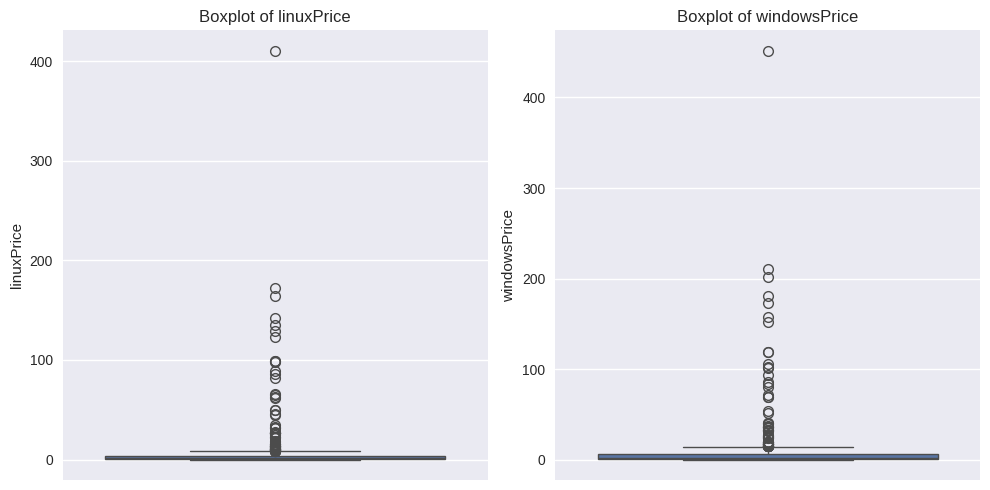

In [ ]:
# Step 3: Outlier detection (boxplots)

plt.figure(figsize=(10, 5))

for i, col in enumerate(['linuxPrice', 'windowsPrice'], start=1):

    plt.subplot(1, 2, i)

    sns.boxplot(data[col])

    plt.title(f'Boxplot of {col}')

plt.tight_layout()


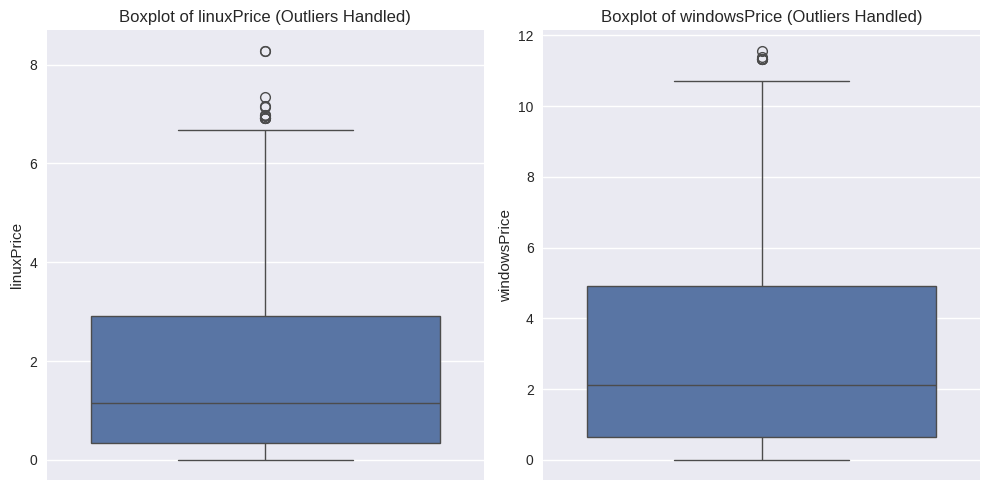

In [ ]:
def handle_outliers_iqr(data, column):
    """
    Handles outliers using the Interquartile Range (IQR) method.

    Args:
        data: The DataFrame containing the data.
        column: The name of the column to handle outliers in.

    Returns:
        DataFrame: The DataFrame with outliers removed or capped.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

# Apply the outlier handling function to 'linuxPrice' and 'windowsPrice'
data = handle_outliers_iqr(data, 'linuxPrice')
data = handle_outliers_iqr(data, 'windowsPrice')

# Replot the boxplots to visualize the data after outlier handling
plt.figure(figsize=(10, 5))
for i, col in enumerate(['linuxPrice', 'windowsPrice'], start=1):
    plt.subplot(1, 2, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col} (Outliers Handled)')
plt.tight_layout()
plt.show()

##Data visualization, focusing on price distributions and regional analysis.

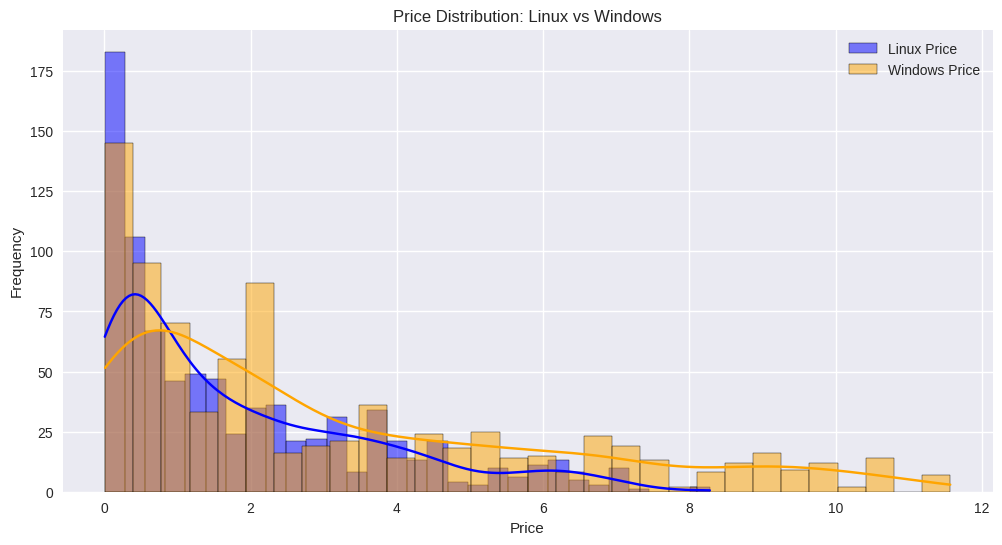

In [ ]:
# Step 1: Visualizing price distributions for Linux and Windows
plt.figure(figsize=(12, 6))
sns.histplot(data['linuxPrice'], kde=True, color='blue', label='Linux Price', bins=30)
sns.histplot(data['windowsPrice'], kde=True, color='orange', label='Windows Price', bins=30)
plt.title('Price Distribution: Linux vs Windows')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

create a histogram to compare the price distributions of Linux and Windows, overlaying their kernel density estimates.

The histogram above compares the price distributions for Linux and Windows, showing that Linux prices are generally lower and more concentrated, while Windows prices have a wider range.

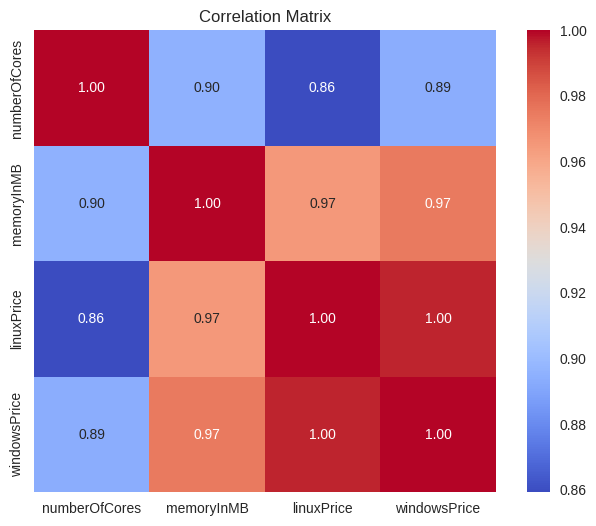

In [ ]:
# Heatmap of correlations

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)

plt.title('Correlation Matrix')

plt.show()


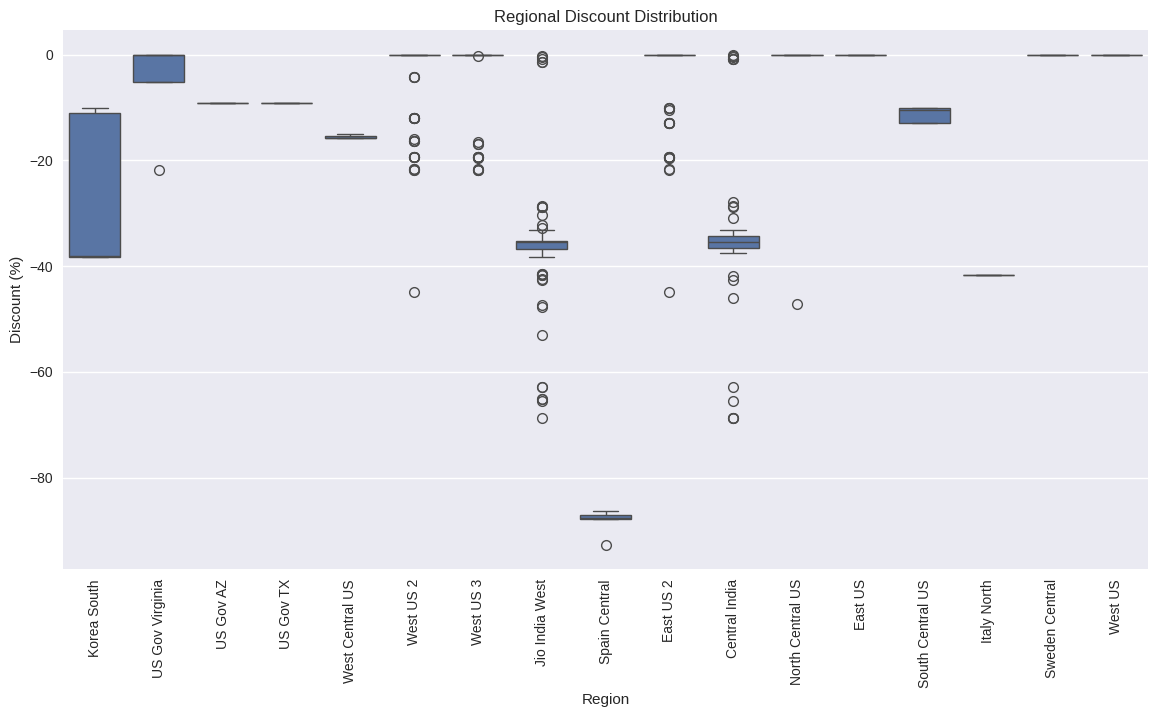

In [ ]:
# Step 2: Analyzing regional discounts
plt.figure(figsize=(14, 7))
sns.boxplot(x='region', y='discount', data=data)
plt.xticks(rotation=90)
plt.title('Regional Discount Distribution')
plt.xlabel('Region')
plt.ylabel('Discount (%)')
plt.show()

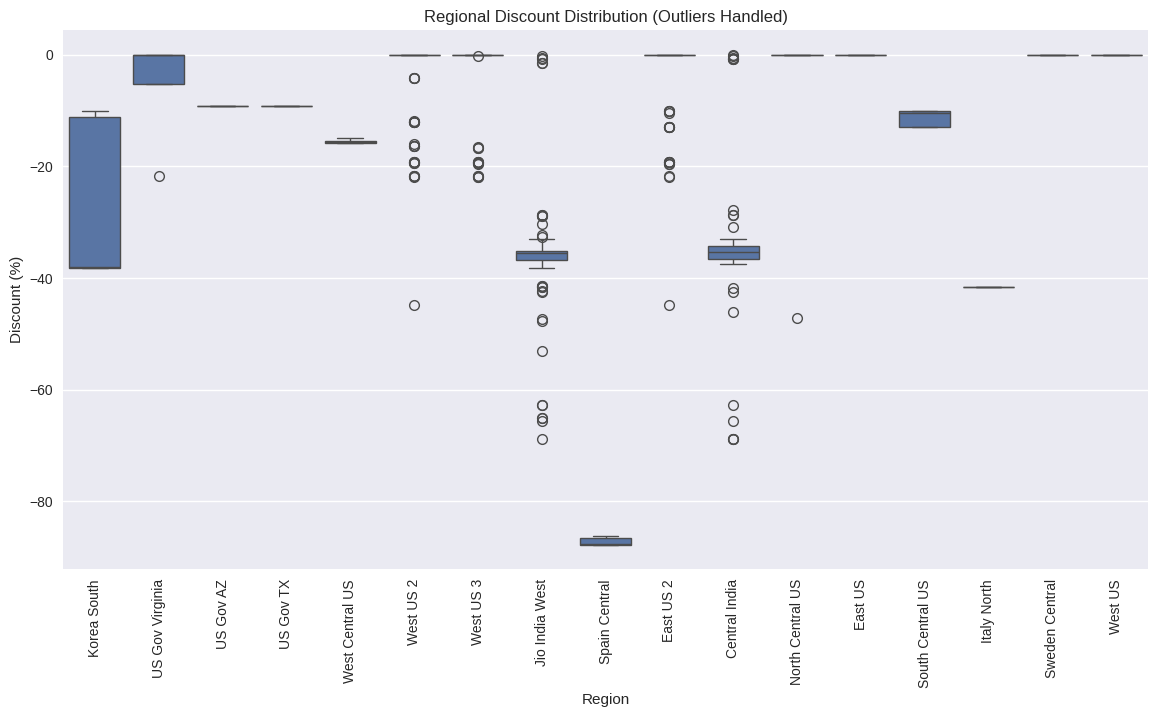

Regions with the best median discounts: West US 3, US Gov Virginia, East US 2


In [ ]:
# Step 2: Analyzing regional discounts with outlier handling
plt.figure(figsize=(14, 7))

# Handle outliers using the IQR method
Q1 = data['discount'].quantile(0.25)
Q3 = data['discount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = data[(data['discount'] >= lower_bound) & (data['discount'] <= upper_bound)]

# Create the boxplot with filtered data
sns.boxplot(x='region', y='discount', data=filtered_data)
plt.xticks(rotation=90)
plt.title('Regional Discount Distribution (Outliers Handled)')
plt.xlabel('Region')
plt.ylabel('Discount (%)')
plt.show()

# Identify regions with the best discounts
best_discount_regions = filtered_data.groupby('region')['discount'].median().sort_values(ascending=False).index[:3]
print(f"Regions with the best median discounts: {', '.join(best_discount_regions)}")

The boxplot above shows the distribution of discounts across different regions, highlighting which regions offer the highest and most consistent discounts

Step 3: Cost-effectiveness analysis by calculating price per core and price per MB of memory.

In [ ]:
# Step 3: Cost-effectiveness analysis
# Calculating price per core and price per MB of memory for Linux and Windows
data['price_per_core_linux'] = data['linuxPrice'] / data['numberOfCores']
data['price_per_core_windows'] = data['windowsPrice'] / data['numberOfCores']
data['price_per_mb_linux'] = data['linuxPrice'] / data['memoryInMB']
data['price_per_mb_windows'] = data['windowsPrice'] / data['memoryInMB']

# Displaying the first few rows of the updated dataset
print('Updated dataset with cost-effectiveness metrics:')
print(data[['name', 'price_per_core_linux', 'price_per_core_windows', 'price_per_mb_linux', 'price_per_mb_windows']].head())

Updated dataset with cost-effectiveness metrics:
       name  price_per_core_linux  price_per_core_windows  price_per_mb_linux  \
0  Basic_A0                0.0180                  0.0180            0.024000   
1  Basic_A1                0.0230                  0.0320            0.013143   
2  Basic_A2                0.0395                  0.0665            0.022571   
3  Basic_A3                0.0440                  0.0740            0.025143   
4  Basic_A4                0.0440                  0.0740            0.025143   

   price_per_mb_windows  
0              0.024000  
1              0.018286  
2              0.038000  
3              0.042286  
4              0.042286  


computes the price per core and price per MB of memory for Linux and Windows servers, and displays the updated dataset with these metrics.

 visualize the above metrics to identify trends and compare cost-effectiveness across configurations.

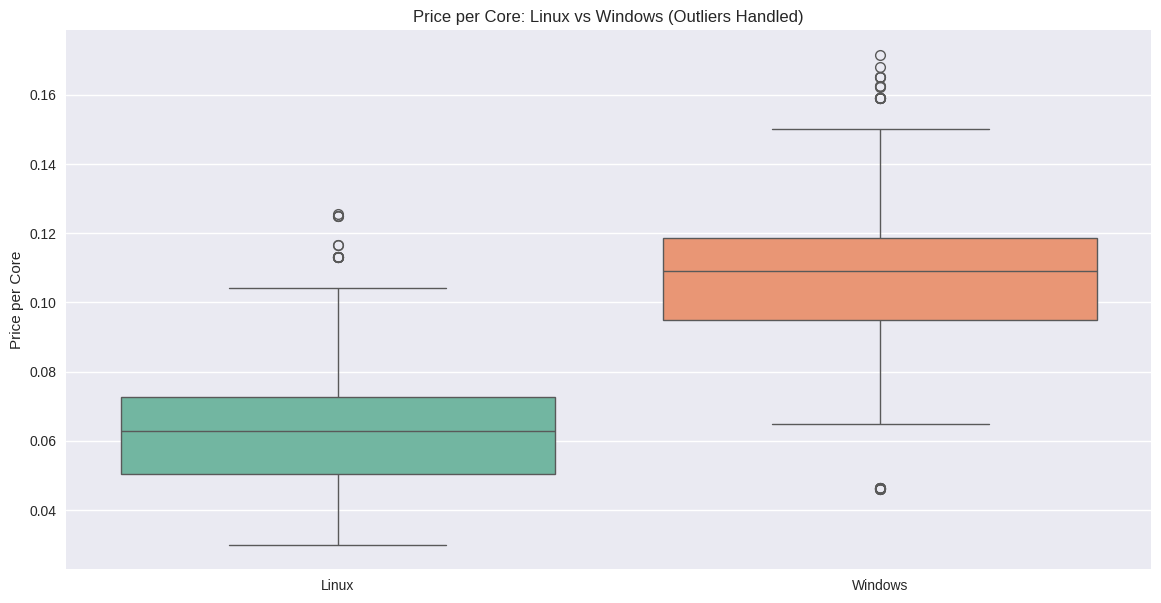

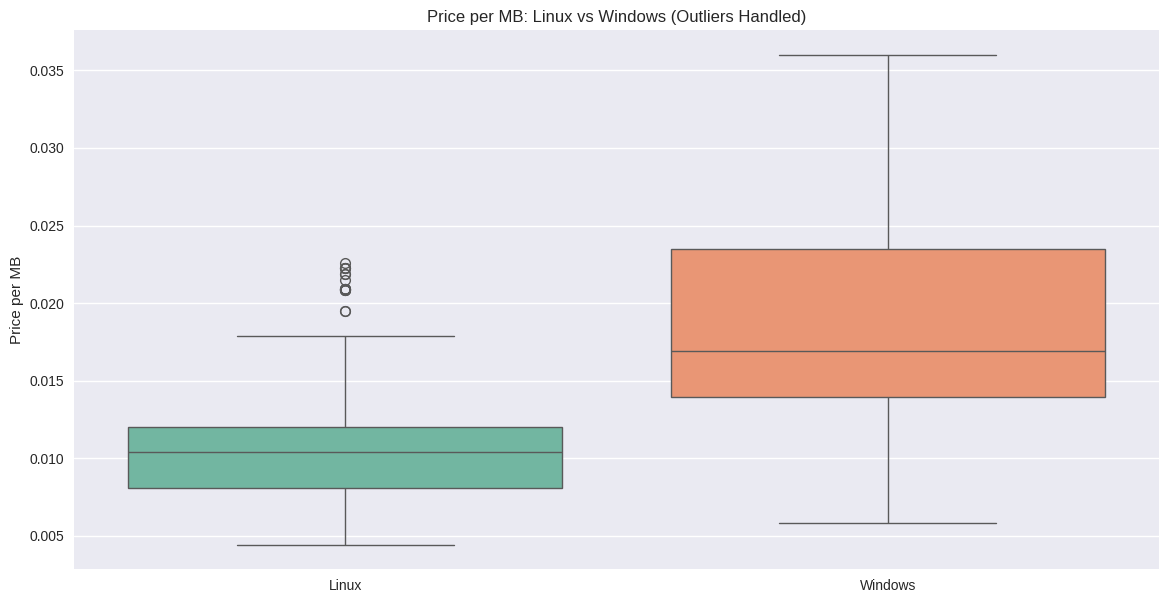

In [ ]:
# Visualizing cost-effectiveness metrics with outlier handling
def handle_outliers_iqr(data, column):
    """
    Handles outliers using the Interquartile Range (IQR) method.

    Args:
        data: The DataFrame containing the data.
        column: The name of the column to handle outliers in.

    Returns:
        DataFrame: The DataFrame with outliers removed or capped.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

# Handling outliers for relevant columns
for col in ['price_per_core_linux', 'price_per_core_windows', 'price_per_mb_linux', 'price_per_mb_windows']:
    data = handle_outliers_iqr(data, col)


plt.figure(figsize=(14, 7))
sns.boxplot(data=[data['price_per_core_linux'], data['price_per_core_windows']], palette='Set2')
plt.xticks([0, 1], ['Linux', 'Windows'])
plt.title('Price per Core: Linux vs Windows (Outliers Handled)')
plt.ylabel('Price per Core')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=[data['price_per_mb_linux'], data['price_per_mb_windows']], palette='Set2')
plt.xticks([0, 1], ['Linux', 'Windows'])
plt.title('Price per MB: Linux vs Windows (Outliers Handled)')
plt.ylabel('Price per MB')
plt.show()

The visualizations for cost-effectiveness metrics (price per core and price per MB) have been successfully generated, showing comparisons between Linux and Windows

In [ ]:
# Step 5: Simple regression model to predict 'windowsPrice'

X = data[['numberOfCores', 'memoryInMB', 'linuxPrice']]

y = data['windowsPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)




In [ ]:
# Print predicted values
print("Predicted values:", y_pred)

# Calculate and print R-squared
r_squared = model.score(X_test, y_test)
print("R-squared:", r_squared)

# Calculate and print Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Predicted values: [ 0.80285929 10.38204823  1.32736455  3.08942632  2.43987665  4.11163469
  0.80571412  9.89082121  0.3851288   6.50968415  2.92598374  1.90059983
  2.89521808 10.69162771  4.21931451  5.98666789  0.18910222  0.70690407
  0.85285349  5.98666789  3.07934337  8.47334103  3.48093862  0.21794503
  3.82437455  0.17179653  1.72888187  6.55321879  0.80285929  1.91201897
  6.72860074  0.18097696  6.98505213  0.4148393   1.43890588  3.24325463
  5.64833181  2.9817465   0.16117156  2.68947271  4.35537599  3.67140242
  0.18333366  5.67901127  9.85810612  0.21313789  3.24325463  0.92012392
  6.98505213  2.68600195  0.39126962  4.4842072   6.58509852  1.63460313
  0.25196722  1.23742426  1.86342274  0.17136269  4.22508307  0.44945067
  5.23299537  1.76733894  5.23299537  3.48093862  2.90194807 10.46088524
  0.72805546  0.92012392  2.9817465   7.53883404  4.4842072   1.64619915
  0.11805575  1.61003987  2.9173309   2.9817465   0.0653326   0.32744319
  1.53467362  2.73113048  0.19583

In [ ]:
# Regression results

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)



regression_results = {

    "Mean Squared Error": mse,

    "R^2 Score": r2,

    "Model Coefficients": model.coef_,

    "Intercept": model.intercept_

}


In [ ]:
# Print regression results
for metric, value in regression_results.items():
    print(f"{metric}: {value}")

Mean Squared Error: 0.1116658273415123
R^2 Score: 0.9862420188585356
Model Coefficients: [4.65769508e-02 2.94587395e-04 9.61426939e-01]
Intercept: -0.02317488773722598


In [ ]:
# Step 6: Save findings for interactive exploration in the notebook

updated_data_path = '/mnt/data/updated_data.csv'

data.to_csv(updated_data_path, index=False)



regression_results, updated_data_path